INFO flower 2022-12-22 00:50:54,547 | grpc.py:50 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2022-12-22 00:50:54,549 | connection.py:38 | ChannelConnectivity.IDLE
DEBUG flower 2022-12-22 00:50:54,551 | connection.py:38 | ChannelConnectivity.READY


2999/2999 [==============================] - 771s 257ms/step - loss: 36.4675 - mae: 4.5858


DEBUG flower 2022-12-22 02:15:42,860 | connection.py:109 | gRPC channel closed
INFO flower 2022-12-22 02:15:42,861 | app.py:149 | Disconnect and shut down


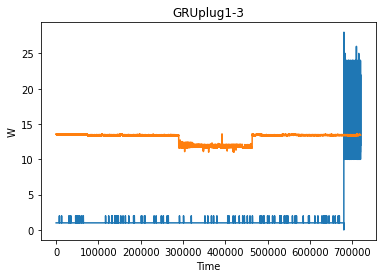

In [3]:
import flwr as fl


import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
np.random.seed(1337)
import matplotlib.pyplot as plt
from keras.layers.core import Dropout
from keras.layers import Dense, Input,Flatten
from keras.layers import Conv1D
from tensorflow import keras
from keras.layers import Conv1D, MaxPooling1D, Embedding, SimpleRNN,LSTM,GRU,Bidirectional
from keras import optimizers

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.max_rows=50

from keras.layers import Reshape

from keras import backend as K
import pandas as pd
import keras
from keras.preprocessing.sequence import TimeseriesGenerator
keras.backend.set_epsilon(1)

aggregate_df1 = pd.read_csv('/home/awinlab/Documents/kevin/elec110.csv',index_col='datetime',parse_dates=True)
aggregate_df1 = aggregate_df1[:900000]
training_size = int(len(aggregate_df1) * 0.8)
aggregate_df_train = aggregate_df1[training_size:]
aggregate_df_test = aggregate_df1[:training_size]

plug1_1 = pd.read_csv('/home/awinlab/Documents/kevin/plug1-3.csv',index_col='datetime',parse_dates=True)
plug1_1 = plug1_1[:900000]
plug1_1_train = plug1_1[training_size:]
plug1_1_test =  plug1_1[:training_size]

X_train = aggregate_df_train.drop(['device', 'vo', 'cu', 'reactive', 'apparent', 'pf', 'freq'],axis=1)
X_test = aggregate_df_test.drop(['device', 'vo', 'cu', 'reactive', 'apparent', 'pf', 'freq'],axis=1)
y_train = plug1_1_train.drop(['device', 'vo', 'cu', 'reactive', 'apparent', 'pf', 'freq'],axis=1)
y_test = plug1_1_test.drop(['device', 'vo', 'cu', 'reactive', 'apparent', 'pf', 'freq'],axis=1)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

in_seq = X_train.reshape((len(X_train), 1))
out_seq = y_train.reshape((len(y_train), 1))

n_input = 100
nb_out = 100
train_generator = TimeseriesGenerator(in_seq, out_seq, length=n_input, batch_size=60)

in_seq_test = X_test.reshape((len(X_test), 1))
out_seq_test = y_test.reshape((len(y_test), 1))

test_generator = TimeseriesGenerator(in_seq_test, out_seq_test, length=100, batch_size=60)


def rete(y_true, y_pred):
      # Lambda(lambda x: x[0]/x[1])([K.abs(y_pred - y_true),K.maximum(y_pred, y_true)])
    return (K.abs(y_pred - y_true) / K.maximum(y_pred, y_true))

nb_features = 1
input_shape=(n_input, nb_features)
model_input = Input(shape=input_shape)

x = Conv1D(16, 4, activation="relu", padding="same", strides=1, input_shape=input_shape)(model_input)
x = (Conv1D(8, 4, activation="relu", padding="same", strides=1))(x)
x = (Bidirectional(GRU(64, return_sequences=True, stateful=False), merge_mode='concat'))(x)
x = (Bidirectional(GRU(128, return_sequences=False, stateful=False), merge_mode='concat'))(x)
x = (Dense(64, activation='relu'))(x)
x = (Dense(1, activation='linear'))(x)
model = keras.Model(model_input, x)

adam = keras.optimizers.adam_v2.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='mse', optimizer=adam,metrics=['mae'])

# Define Flower client
class CifarClient(fl.client.NumPyClient):
    def get_parameters(self, config):
        return model.get_weights()

    def fit(self, parameters, config):
        model.set_weights(parameters)
        model.fit_generator(train_generator, epochs=1, verbose=1)
        return model.get_weights(), len(X_train), {}

    def evaluate(self, parameters, config):
        model.set_weights(parameters)
        loss, accuracy = model.evaluate_generator(test_generator)
    
        return loss, len(X_test), {"accuracy": accuracy}

# Start Flower client
fl.client.start_numpy_client(server_address="127.0.0.1:8080", client=CifarClient())

predict = model.predict_generator(test_generator)
plt.plot(y_test)
plt.plot(predict)
plt.xlabel('Time')  
plt.ylabel("W")
plt.title("GRUplug1-3")
plt.show()